In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1. Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/CDS525/"
columns=['sentiment','text']
df_raw = pd.read_csv(data_path+'all-data.csv', encoding='latin-1', header=None, names=columns)
df_raw

Mounted at /content/drive/


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [3]:
df_raw.describe()

,sentiment,text
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


# 2. Data preparing

## 2.1 Check NaN values

In [4]:
df_raw.isna().sum()

sentiment    0
text         0
dtype: int64

## 2.2 Remove duplicate rows

In [5]:
df_raw.duplicated().sum()

6

In [6]:
df_raw = df_raw.drop_duplicates()

In [7]:
df_raw.shape

(4840, 2)

## 2.3 Sentiment distribution

In [8]:
sentiment_counts = df_raw['sentiment'].value_counts()
sentiment_counts

sentiment
neutral     2873
positive    1363
negative     604
Name: count, dtype: int64

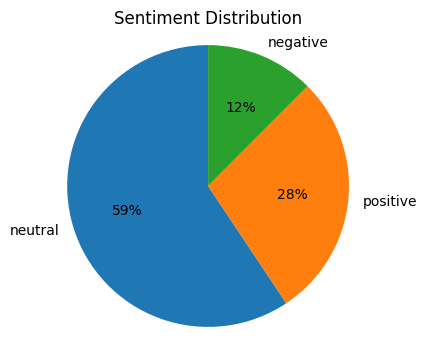

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.0f%%', startangle=90)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

## 2.4 Data cleaning

In [10]:
!pip install nltk

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Remove stopwords

In [11]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

### Normalization

In [12]:
import re, string

def normalize(text):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    mention_re = re.compile('@(\w+)')
    # convert to lowercase
    text = text.lower()
    # remove hyperlinks
    text = url_re.sub(' ', text)
    # remove @mentions
    text = mention_re.sub(' ', text)
    # remove puncuation
    text = punc_re.sub(' ', text)
    # remove whitespace
    text = text.strip()
    return text

### Lemmatization

In [13]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

### Define data_clean func

In [14]:
def data_clean(text):
    normalized_text = normalize(text)                    ## Normalization
    lmtzr_test= lemmatize_text(normalized_text)          ## Lemmatization
    remove_stops_text = remove_stopwords(lmtzr_test)     ## Remove Stopwords
    return remove_stops_text

In [15]:
df_cleaned = df_raw.copy()

In [16]:
df_cleaned['cleaned_text'] = df_cleaned['text'].apply(data_clean)
df_cleaned.head(5)

,sentiment,text,cleaned_text
0,neutral,"According to Gran , the company has no plans t...",according gran company ha plan move production...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area le 100 000...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year 2009 2...


## 2.5 Label processing -- Encode the sentiment labels

In [17]:
y_one_hot = pd.get_dummies(df_cleaned['sentiment'])

In [18]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df_cleaned['label'] = df_cleaned['sentiment'].map(label_map)
df_cleaned.head(5)

,sentiment,text,cleaned_text,label
0,neutral,"According to Gran , the company has no plans t...",according gran company ha plan move production...,1
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area le 100 000...,1
2,negative,The international electronic industry company ...,international electronic industry company elco...,0
3,positive,With the new production plant the company woul...,new production plant company would increase ca...,2
4,positive,According to the company 's updated strategy f...,according company updated strategy year 2009 2...,2


## 2.6 Splite train set and test set

In [19]:
from sklearn.model_selection import train_test_split

X = df_cleaned['cleaned_text']
y_encode = df_cleaned['label']

X_train, X_test, y_train_encode, y_test_encode = train_test_split(X, y_encode, test_size=0.2, random_state=42)
_, _, y_train_one_hot, y_test_one_hot = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

print(f'Training set size: {np.size(X_train)}\nTest set size: {np.size(X_test)}')

Training set size: 3872
Test set size: 968


## 2.7 Feature processing -- Tokenizing & Padding

In [20]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

In [21]:
# Query the maximum length of the text
text_len_list = X_train_df.cleaned_text.str.split().apply(len).to_list()
max_text_len = max(text_len_list)
print(f'The maximum length of the text is {max_text_len}.')

# Query text vocabulary
word_set = set()
vocabulary = 0

for text in X_train_df['cleaned_text']:
    words = text.split()
    # Use set to remove duplicates
    word_set.update(words)

vocabulary = len(word_set)

print(f'Text vocabulary: {vocabulary}.')

The maximum length of the text is 69.
Text vocabulary: 8197.


In [22]:
!pip install tensorflow

In [23]:
from transformers import TFDistilBertModel, DistilBertConfig, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = vocabulary
max_len= 100

def tokenize_pad_sequences(text, tokenizer=None):
    # Text tokenization
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_words, split=' ')
        tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

X_train_tokenized, tokenizer = tokenize_pad_sequences(X_train_df['cleaned_text'])
X_test_tokenized, _ = tokenize_pad_sequences(X_test_df['cleaned_text'], tokenizer)

print(f'Tokenized training set size: {X_train_tokenized.shape}\nTokenized test set size: {X_test_tokenized.shape}')

Tokenized training set size: (3872, 100)
Tokenized test set size: (968, 100)


# 3. Model
CNN，Bidirectional LSTM，MLP，DistilBERT

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D,GlobalMaxPooling1D, Bidirectional, Dense, Dropout,Flatten, LSTM, Input

In [25]:
vocab_size = 10000
embedding_size = 64
max_len = 100

## LSTM

In [26]:
def build_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(max_len,)))
    lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
    lstm_model.add(Bidirectional(LSTM(units=32)))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(units=3, activation='softmax'))
    return lstm_model

lstm_model = build_lstm_model()
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 665027 (2.54 MB)
Trainable params: 665027 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## CNN

In [27]:
def build_cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Input(shape=(max_len,)))
    cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(units=3, activation='softmax'))
    return cnn_model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 64)            0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 49, 64)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                

## MLP

In [28]:
def build_mlp_model():
    mlp_model = Sequential()
    mlp_model.add(Input(shape=(max_len,)))
    mlp_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
    mlp_model.add(Flatten())
    mlp_model.add(Dropout(0.4))
    mlp_model.add(Dense(units=64, activation='relu'))
    mlp_model.add(Dense(units=3, activation='softmax'))
    return mlp_model

mlp_model = build_mlp_model()
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dropout_2 (Dropout)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                409664    
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1049859 (4.00 MB)
Trainable params: 1049859 (4.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## distilBERT

In [29]:
from transformers import TFDistilBertModel, DistilBertConfig, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Layer,LeakyReLU
from tensorflow.keras.models import Model
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.bert_model(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0]


def encode_data(tokenizer, texts, max_length=100):
    tokenized = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )
    return tokenized['input_ids'], tokenized['attention_mask']

X_train_input_ids, attention_mask_train = encode_data(tokenizer, X_train, max_length=100)
X_test_input_ids, attention_mask_test = encode_data(tokenizer, X_test, max_length=100)

def build_distilbert_model(max_length=100, num_labels=3, dropout_rate=0.4, learning_rate=0.001):
    config = DistilBertConfig(num_labels=num_labels, dropout=dropout_rate)
    bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

    input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    bert_layer = BertLayer(bert_model)
    bert_output = bert_layer([input_ids, attention_mask])

    output = Dropout(dropout_rate)(bert_output)
    output = Dense(256)(output)  # Remove activation here
    output = LeakyReLU(alpha=0.01)(output)  # Add LeakyReLU with a small alpha
    output = Dropout(0.3)(output)
    output = Dense(128)(output)  # Remove activation here
    output = LeakyReLU(alpha=0.01)(output)  # Repeat for other layers
    output = Dropout(0.15)(output)
    output = Dense(units=num_labels, activation='softmax')(output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model, tokenizer

model, tokenizer = build_distilbert_model()
model.summary()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 100)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_layer (BertLayer)      (None, 768)                  6636288   ['input_ids[0][0]',           
                                                          0          'attention_mask[0][0]']      
                                                                                              

# 4. Define Functions

## 4.1 Training and evaluation function

In [30]:

from tensorflow.keras.optimizers import Adam

def train_and_evaluate(model, X_train, y_train, X_test, y_test, lr, loss, epochs, batch_size, verbose=0, callbacks=None):
    # Configure the optimizer
    optimizer = Adam(learning_rate=lr)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    if isinstance(X_train, list):
        history = model.fit(
            X_train, y_train, validation_data=(X_test, y_test),
            batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=callbacks)
    else:
        history = model.fit(
            X_train, y_train, validation_data=(X_test, y_test),
            batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=callbacks)

    # Predict and evaluate the model
    y_pred = model.predict(X_test)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=verbose)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=verbose)

    return train_loss, train_acc, test_acc, y_pred

## 4.2 Create indicator result dataframe


In [31]:
def create_result_df(epoch_list, build_model_function, X_train, y_train, X_test, y_test, lr, loss, batch_size):
    Training_loss_list = []
    Training_accuracy_list = []
    Test_accuracy_list = []

    for epoch in epoch_list:
        result = build_model_function()
        model = result if not isinstance(result, tuple) else result[0]  # 只取元组的第一个元素（模型）
        train_loss, train_acc, test_acc, _ = train_and_evaluate(
            model, X_train, y_train, X_test, y_test, lr, loss, epoch, batch_size)
        Training_loss_list.append(train_loss)
        Training_accuracy_list.append(train_acc)
        Test_accuracy_list.append(test_acc)

    return pd.DataFrame({
        "Epochs": epoch_list,
        "Training_loss_list": Training_loss_list,
        "Training_accuracy_list": Training_accuracy_list,
        "Test_accuracy_list": Test_accuracy_list
    })

## 4.3 Visualization

In [32]:
def visualize(df,epoch_list,loss_code,index=0,para_value=0):
    Training_loss = list(df['Training_loss_list'])
    Training_accuracy = list(df['Training_accuracy_list'])
    Test_accuracy = list(df['Test_accuracy_list'])
    labels = sorted(epoch_list)

    # Create the first subgraph
    ax1 = plt.subplot(gs[index])

    # Set the position of the bar plot
    x = np.arange(len(Training_loss))
    # Set the width of each bar
    width = 3/10

    # Create the first bar plot
    ax1.bar(x - width, Training_loss, width=width, color='b', alpha=0.5, label='Training loss')
    ax1.set_ylabel('Training loss', color='b')
    ax1.set_xticks(np.arange(len(Training_loss)))
    ax1.set_xticklabels(labels)
    ax1.set_xlabel('epochs')

    # Create the subaxis
    ax2 = ax1.twinx()

    # Create the second or third bar plot
    ax2.bar(x, Training_accuracy, width=width, color='g', alpha=0.5, label='Training accuracy')
    ax2.bar(x + width, Test_accuracy, width=width, color='r', alpha=0.5, label='Test accuracy')
    ax2.set_ylabel('Accuracy', color='r')

    # Set the scale range of the subaxis
    ax2.set_ylim([0, 1])

    # Set legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    ax1.legend(handles, labels, loc='upper right')

    # Set title
    title_l = ''
    title_p = ''
    if loss_code == 's':
        title_l = 'sparse categorical crossentropy'
    elif loss_code == 'c':
        title_l = 'categorical crossentropy'
    else:
        print('loss_code ERROR')

    if para_value == 0:
        title_p = ''
    elif para_value > 1:
        title_p = '\nbatch size='+str(para_value)
    elif para_value <= 1:
        title_p = '\nlearning rate='+str(para_value)
    else:
        print('para_value ERROR')
    title = title_l+title_p
    ax1.set_title(title)

# 5. Performance Visualization

## 5.1 Tune epoch
Training loss, training accuracy, and test accuracy with the change of number of epochs (you can decide the no. of epochs by using a validation set or other methods like setting a terminal
condition) [one figure]

In [33]:
## baseline
epoch= 20
lr = 0.001
loss='sparse_categorical_crossentropy'
batch_size = 32

### LSTM

In [34]:
## Decide no. of epoch
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

temp = train_and_evaluate(build_lstm_model(), X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                   lr, loss, epoch, batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/20
121/121 [==============================] - 31s 221ms/step - loss: 0.8939 - accuracy: 0.6149 - val_loss: 0.7802 - val_accuracy: 0.6519
Epoch 2/20
121/121 [==============================] - 22s 183ms/step - loss: 0.6332 - accuracy: 0.7237 - val_loss: 0.6964 - val_accuracy: 0.7097
Epoch 3/20
121/121 [==============================] - 19s 154ms/step - loss: 0.3671 - accuracy: 0.8605 - val_loss: 0.7560 - val_accuracy: 0.7242
Epoch 4/20
121/121 [==============================] - 19s 154ms/step - loss: 0.2000 - accuracy: 0.9388 - val_loss: 0.9010 - val_accuracy: 0.7324
Epoch 5/20
31/31 [==============================] - 1s 30ms/step - loss: 0.6964 - accuracy: 0.7097


In [35]:
# Changed parameter
epoch_list = [4,6,8]
# Unchanged parameter
lr = 0.001
loss = 'sparse_categorical_crossentropy'
batch_size = 32

# Obtain result
df1 = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                       lr, loss, batch_size)

31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


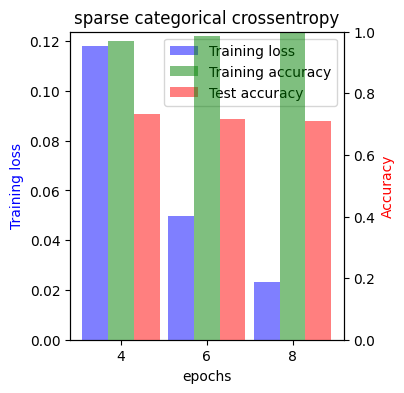

In [36]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
visualize(df1,epoch_list,'s')

plt.show()

### MLP

In [37]:
## Decide no. of epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

temp = train_and_evaluate(build_mlp_model(), X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                   lr, loss, epoch, batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/20
121/121 [==============================] - 8s 58ms/step - loss: 0.8811 - accuracy: 0.6178 - val_loss: 0.8401 - val_accuracy: 0.6333
Epoch 2/20
121/121 [==============================] - 3s 23ms/step - loss: 0.6412 - accuracy: 0.7229 - val_loss: 0.6862 - val_accuracy: 0.7087
Epoch 3/20
121/121 [==============================] - 1s 11ms/step - loss: 0.3265 - accuracy: 0.8838 - val_loss: 0.7018 - val_accuracy: 0.7293
Epoch 4/20
121/121 [==============================] - 1s 11ms/step - loss: 0.1301 - accuracy: 0.9646 - val_loss: 0.6873 - val_accuracy: 0.7479
Epoch 5/20
31/31 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.7087


In [38]:
# Changed parameter
epoch_list = [4,6,8]
# Unchanged parameter
lr = 0.001
loss = 'sparse_categorical_crossentropy'
batch_size = 32

# Obtain result
df1 = create_result_df(epoch_list,build_lstm_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                       lr, loss, batch_size)

31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


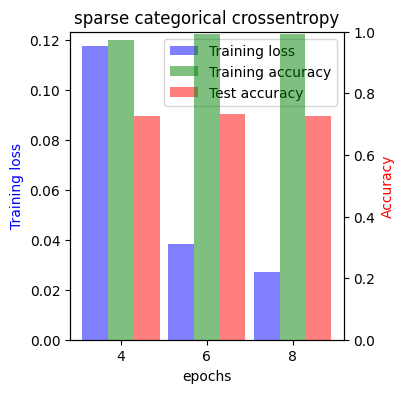

In [39]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))

visualize(df1,epoch_list,'s')

plt.show()

### CNN

In [40]:
## Decide no. of epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

temp = train_and_evaluate(build_cnn_model(), X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                   lr, loss, epoch, batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/20
121/121 [==============================] - 9s 59ms/step - loss: 0.9124 - accuracy: 0.6010 - val_loss: 0.8761 - val_accuracy: 0.6467
Epoch 2/20
121/121 [==============================] - 2s 21ms/step - loss: 0.6895 - accuracy: 0.7107 - val_loss: 0.6896 - val_accuracy: 0.7469
Epoch 3/20
121/121 [==============================] - 2s 13ms/step - loss: 0.4042 - accuracy: 0.8502 - val_loss: 0.6271 - val_accuracy: 0.7448
Epoch 4/20
121/121 [==============================] - 1s 12ms/step - loss: 0.2072 - accuracy: 0.9344 - val_loss: 0.6252 - val_accuracy: 0.7479
Epoch 5/20
121/121 [==============================] - 1s 8ms/step - loss: 0.1095 - accuracy: 0.9703 - val_loss: 0.6704 - val_accuracy: 0.7386
Epoch 6/20
121/121 [==============================] - 1s 6ms/step - loss: 0.0653 - accuracy: 0.9848 - val_loss: 0.7126 - val_accuracy: 0.7335
Epoch 7/20
31/31 [==============================] - 0s 2ms/step - loss: 0.6252 - accuracy: 0.7479


In [41]:
# Changed parameter
epoch_list = [4,6,8]
# Unchanged parameter
lr = 0.001
loss = 'sparse_categorical_crossentropy'
batch_size = 32

# Obtain result
df1 = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                       lr, loss, batch_size)

31/31 [==============================] - 0s 2ms/step


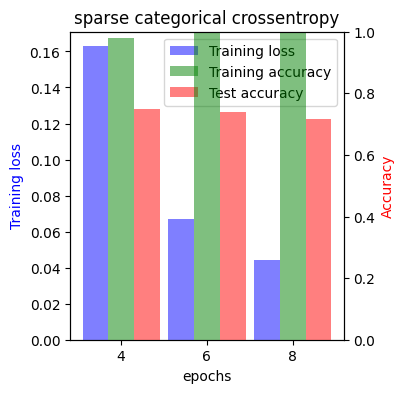

In [42]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs=gridspec.GridSpec(1,3)
visualize(df1,epoch_list,'s')

plt.show()

### distilBERT

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

bert_model, tokenizer = build_distilbert_model(max_length=100, num_labels=3, dropout_rate=0.4, learning_rate=3e-5)
X_train = [X_train_input_ids, attention_mask_train]
y_train = y_train_encode
X_test = [X_test_input_ids, attention_mask_test]
y_test = y_test_encode

temp = train_and_evaluate(bert_model, X_train, y_train, X_test, y_test,
                   lr=3e-5, loss='sparse_categorical_crossentropy', epochs=3, batch_size=32, verbose=1, callbacks=[early_stop])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
121/121 [==============================] - 38s 145ms/step - loss: 0.8002 - accuracy: 0.6420 - val_loss: 0.5706 - val_accuracy: 0.7841
Epoch 2/3
121/121 [==============================] - 12s 100ms/step - loss: 0.4655 - accuracy: 0.8120 - val_loss: 0.4908 - val_accuracy: 0.8037
Epoch 3/3
31/31 [==============================] - 1s 32ms/step - loss: 0.5766 - accuracy: 0.7996


In [44]:
epoch_list = [2, 3, 4]
# Unchanged parameter
lr = 0.001
loss = 'sparse_categorical_crossentropy'
batch_size = 32

df1 = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_encode,
    [X_test_input_ids, attention_mask_test], y_test_encode,
    lr, loss, batch_size
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


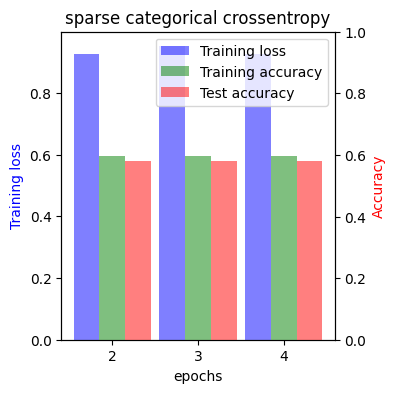

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs=gridspec.GridSpec(1,3)
visualize(df1,epoch_list,'s')

plt.show()

## 5.2 Tune loss function

### LSTM

In [46]:
# Changed parameter
epoch_list = [4,6,8]
loss_list= ['sparse_categorical_crossentropy','categorical_crossentropy']
# Unchanged parameter
lr = 0.001
batch_size = 32

# Obtain result
## sparse_categorical_crossentropy
df1 = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
## categorical_crossentropy
df2 = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
# Plot

31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 2s 29ms/step


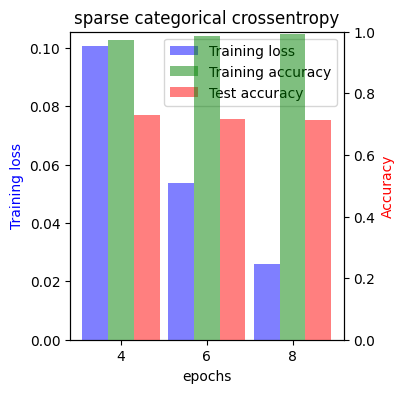

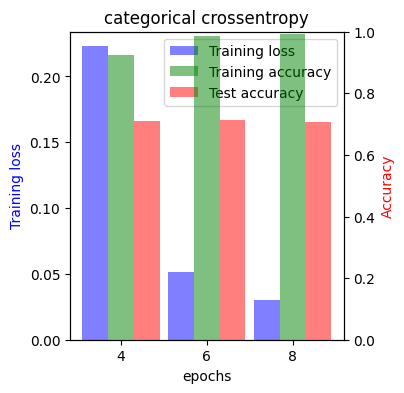

In [47]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df1,epoch_list,'s')

plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df2,epoch_list,'c')

plt.show()

### MLP

In [48]:
# Changed parameter
epoch_list = [4,6,8]
loss_list= ['sparse_categorical_crossentropy','categorical_crossentropy']
# Unchanged parameter
lr = 0.001
batch_size = 32

# Obtain result
## sparse_categorical_crossentropy
df1 = create_result_df(epoch_list, build_mlp_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
## categorical_crossentropy
df2 = create_result_df(epoch_list, build_mlp_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)

# Plot

31/31 [==============================] - 0s 1ms/step


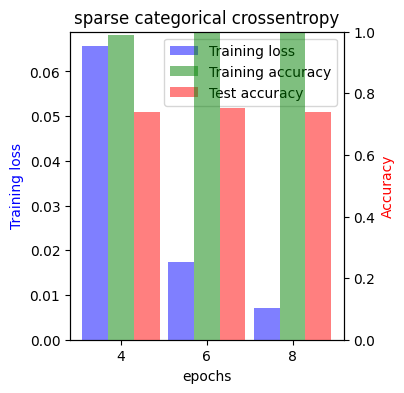

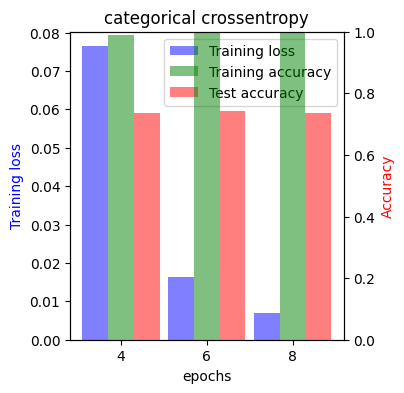

In [49]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df1,epoch_list,'s')

plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df2,epoch_list,'c')

plt.show()

### CNN

In [50]:
# Changed parameter
epoch_list = [4,6,8]
loss_list= ['sparse_categorical_crossentropy','categorical_crossentropy']
# Unchanged parameter
lr = 0.001
batch_size = 32


# Obtain result
## sparse_categorical_crossentropy
df1 = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
## categorical_crossentropy
df2 = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)

31/31 [==============================] - 0s 1ms/step


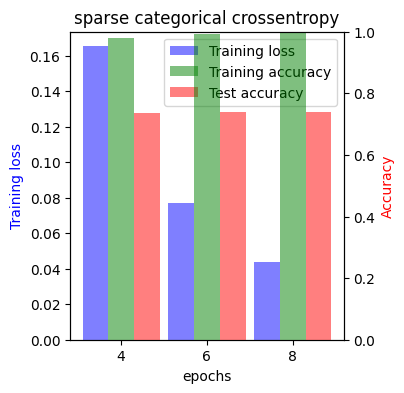

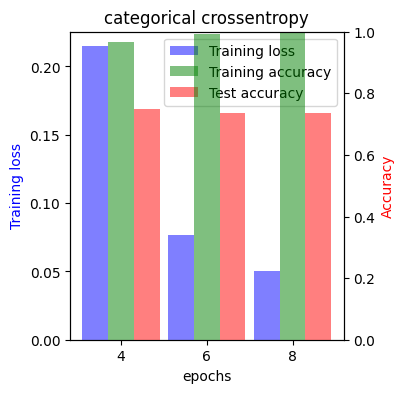

In [51]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df1,epoch_list,'s')

plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df2,epoch_list,'c')

plt.show()

### distilBERT

In [52]:
# Changed parameter
epoch_list = [2,3,4]
loss_list= ['sparse_categorical_crossentropy','categorical_crossentropy']
# Unchanged parameter
lr = 3e-5
batch_size = 32

# Obtain result
## sparse_categorical_crossentropy
df1 = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_encode,
    [X_test_input_ids, attention_mask_test], y_test_encode,
    lr, 'sparse_categorical_crossentropy', batch_size
)
## categorical_crossentropy
df2 = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_one_hot,
    [X_test_input_ids, attention_mask_test], y_test_one_hot,
    lr, 'categorical_crossentropy', batch_size
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 5s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 32ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


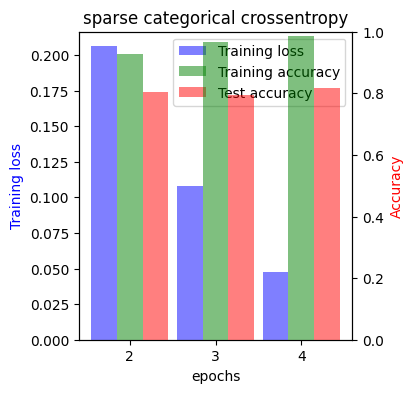

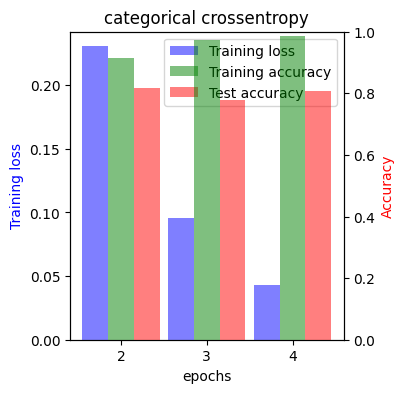

In [53]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df1,epoch_list,'s')

plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))

visualize(df2,epoch_list,'c')

plt.show()

## 5.3 Tune learning rate

### LSTM

In [54]:
# Changed parameter
epoch_list = [4,6,8]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
lr_list = [0.01, 0.001, 0.0001]
# Unchanged parameter
batch_size = 32

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for lr in lr_list:
    df = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
    df_dict_s[lr] = df
## categorical_crossentropy
for lr in lr_list:
    df = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
    df_dict_c[lr] = df

31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 28ms/step


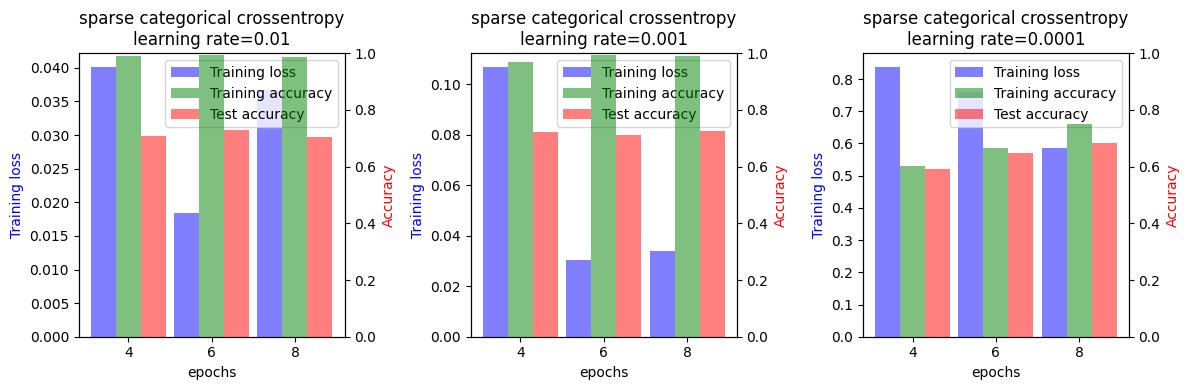

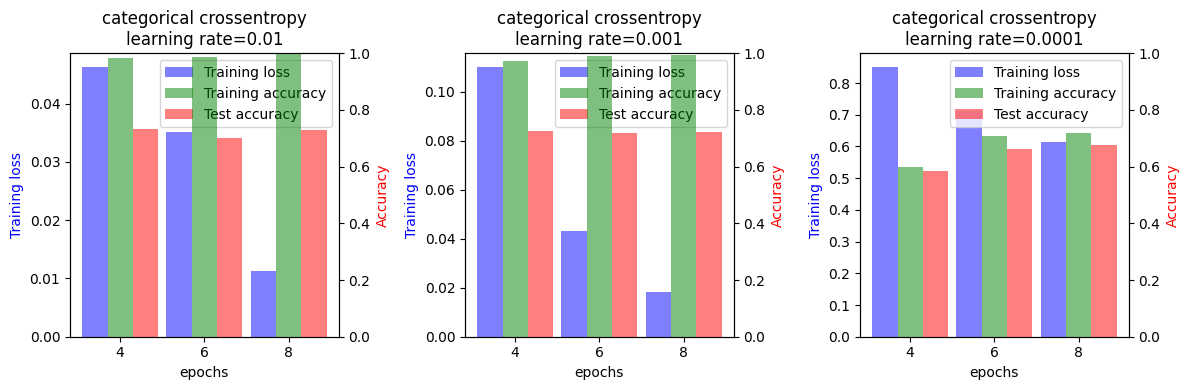

In [55]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

### MLP

In [56]:
# Changed parameter
epoch_list = [4,6,8]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
lr_list = [0.01, 0.001, 0.0001]
# Unchanged parameter
batch_size = 32

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for lr in lr_list:
    df = create_result_df(epoch_list, build_mlp_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
    df_dict_s[lr] = df
## categorical_crossentropy
for lr in lr_list:
    df = create_result_df(epoch_list, build_mlp_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
    df_dict_c[lr] = df

31/31 [==============================] - 0s 1ms/step


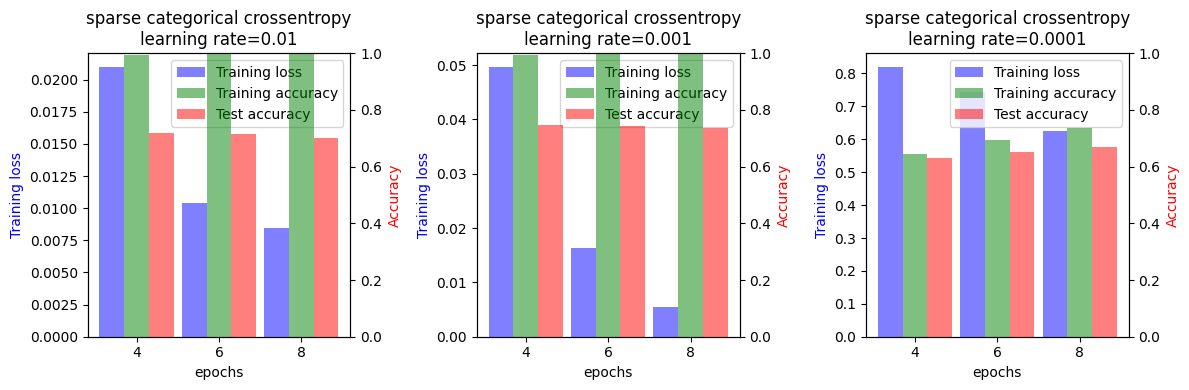

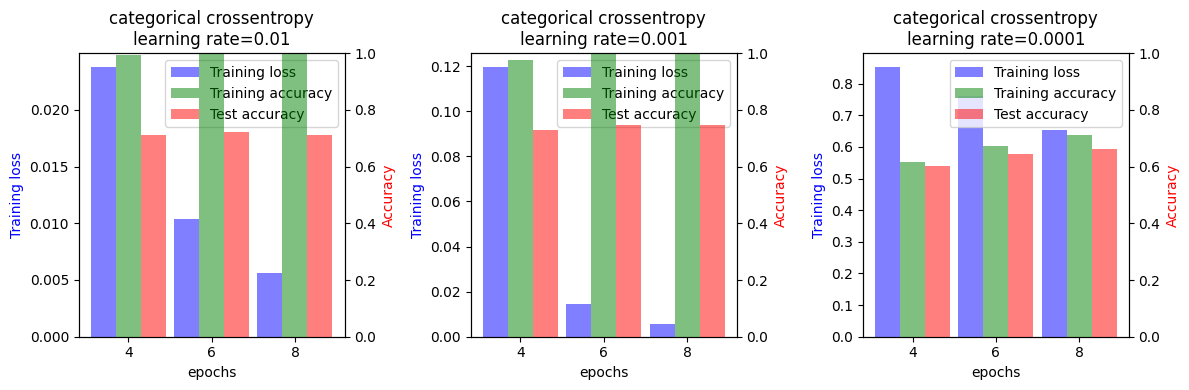

In [57]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

### CNN

In [58]:
# Changed parameter
epoch_list = [4,6,8]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
lr_list = [0.01, 0.001, 0.0001]
# Unchanged parameter
batch_size = 32

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for lr in lr_list:
    df = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
    df_dict_s[lr] = df
## categorical_crossentropy
for lr in lr_list:
    df = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
    df_dict_c[lr] = df

31/31 [==============================] - 0s 1ms/step


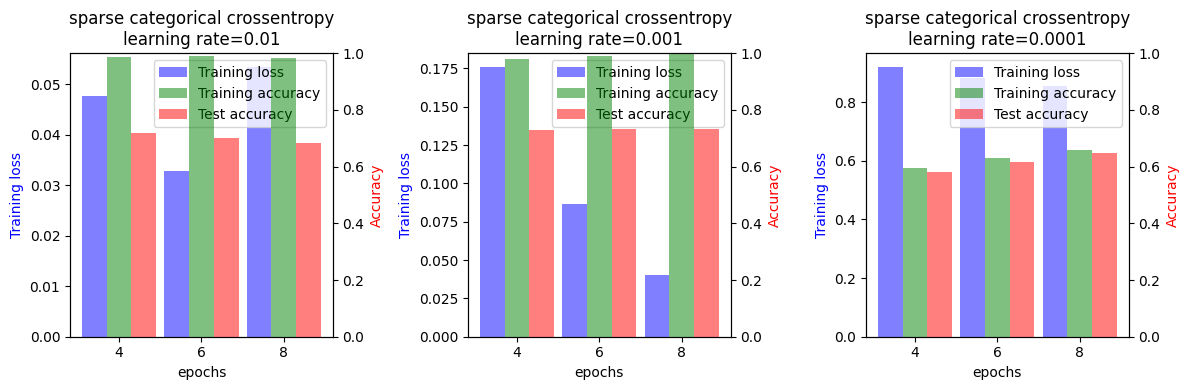

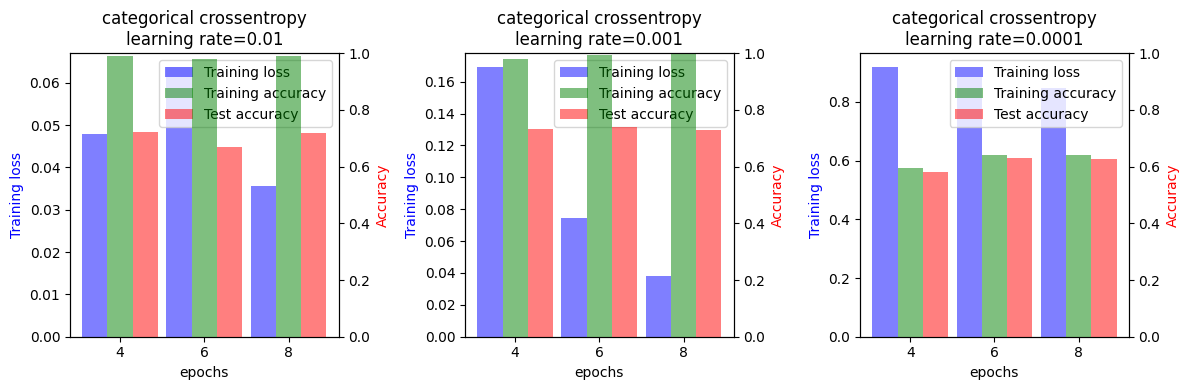

In [59]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

### distilBERT

In [60]:
# Changed parameter
epoch_list = [2,3,4]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
lr_list = [2e-5, 3e-5, 4e-5]
# Unchanged parameter
batch_size = 32

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for lr in lr_list:
    df = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_encode,
    [X_test_input_ids, attention_mask_test], y_test_encode,
    lr, 'sparse_categorical_crossentropy', batch_size
)
    df_dict_s[lr] = df

## categorical_crossentropy
for lr in lr_list:
    df = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_one_hot,
    [X_test_input_ids, attention_mask_test], y_test_one_hot,
    lr, 'categorical_crossentropy', batch_size
)
    df_dict_c[lr] = df

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 7s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 5s 31ms/step


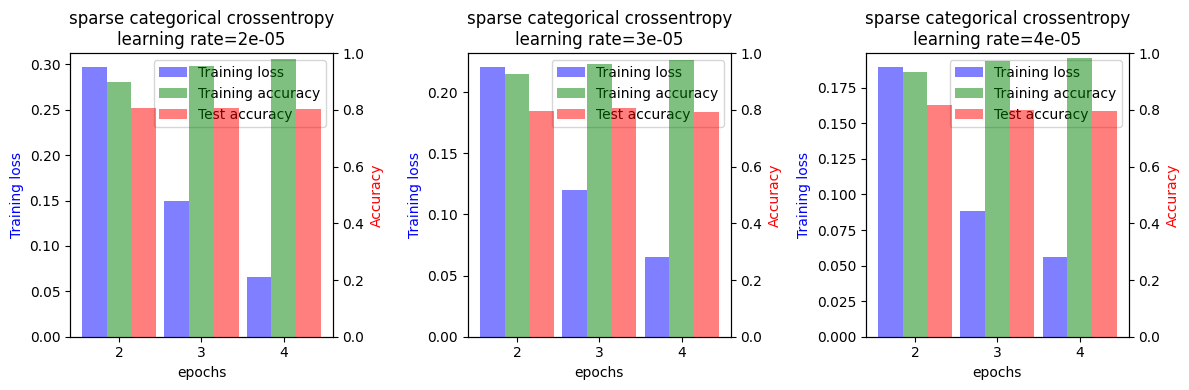

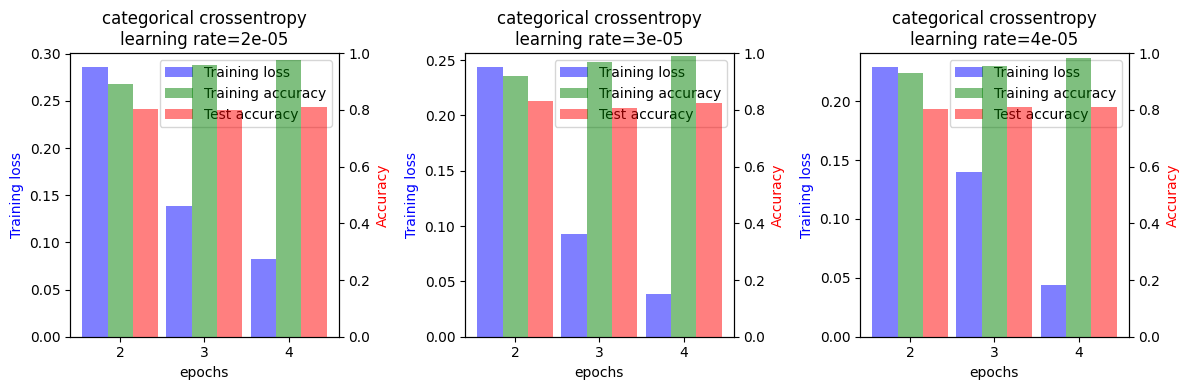

In [61]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(lr_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

## 5.4 Tune batch size

### LSTM

31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 29ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 28ms/step


31/31 [==============================] - 1s 29ms/step


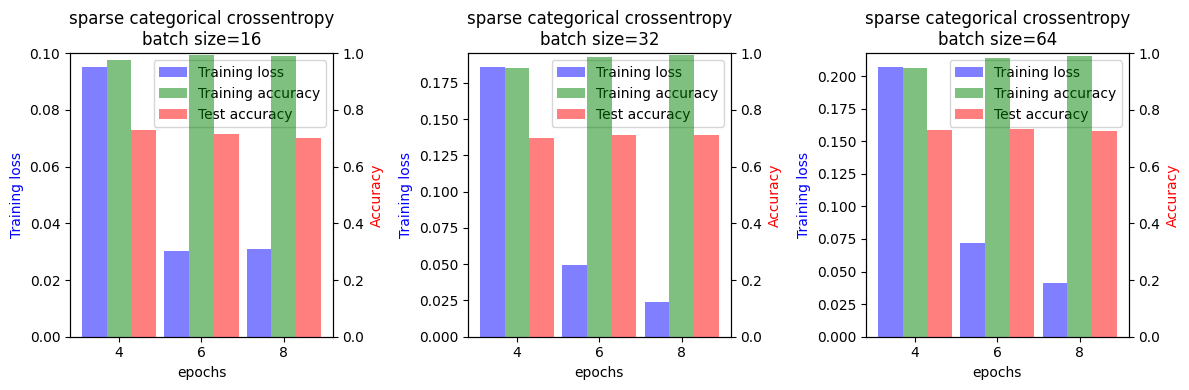

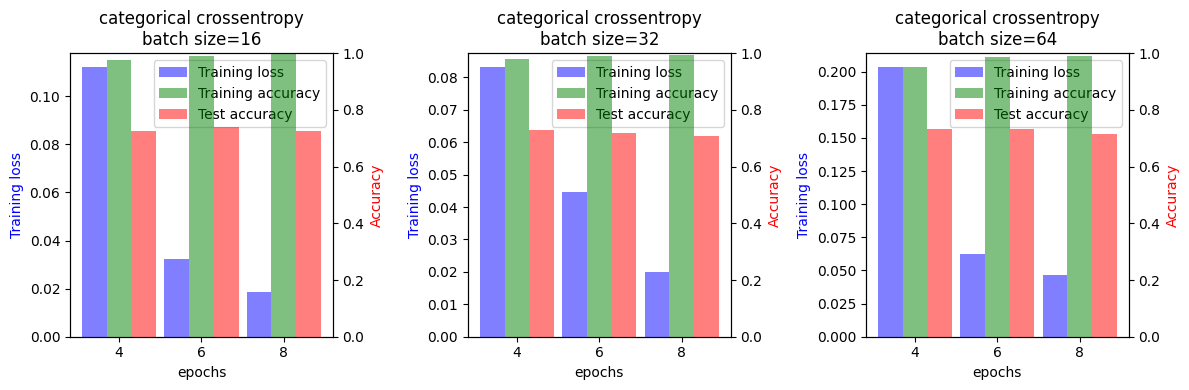

In [62]:
# Changed parameter
epoch_list = [4,6,8]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
batch_size_list = [16, 32, 64]
# Unchanged parameter
lr = 0.001

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
    df_dict_s[batch_size] = df
## categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(epoch_list, build_lstm_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
    df_dict_c[batch_size] = df


# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

### MLP

31/31 [==============================] - 0s 1ms/step


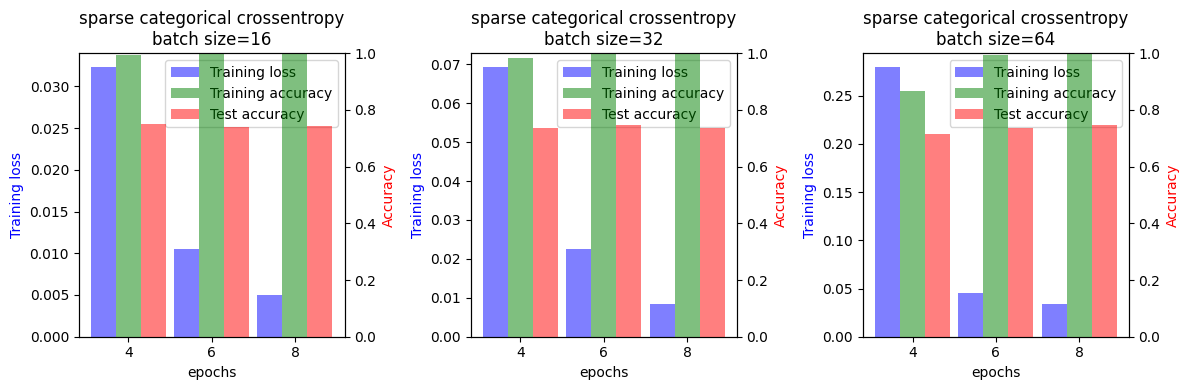

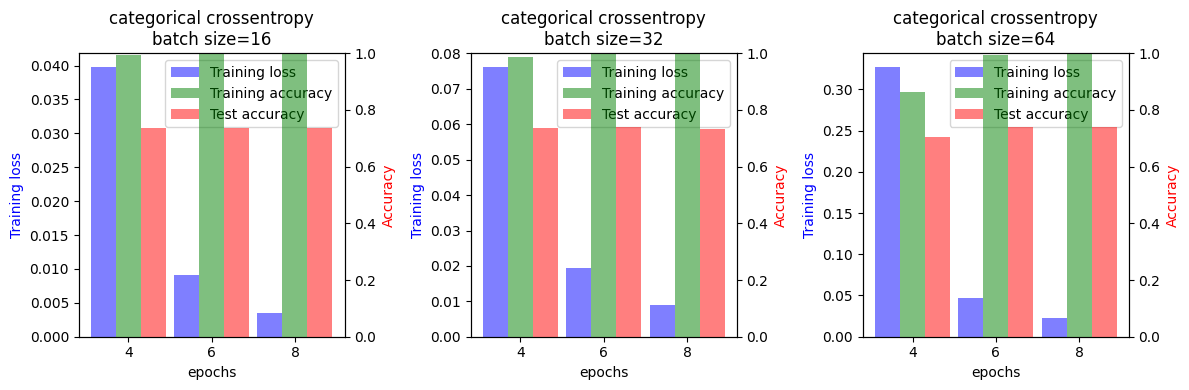

In [63]:
# Changed parameter
epoch_list = [4,6,8]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
batch_size_list = [16, 32, 64]
# Unchanged parameter
lr = 0.001

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(epoch_list, build_mlp_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
    df_dict_s[batch_size] = df
## categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(epoch_list, build_mlp_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
    df_dict_c[batch_size] = df


# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

### CNN

31/31 [==============================] - 0s 1ms/step


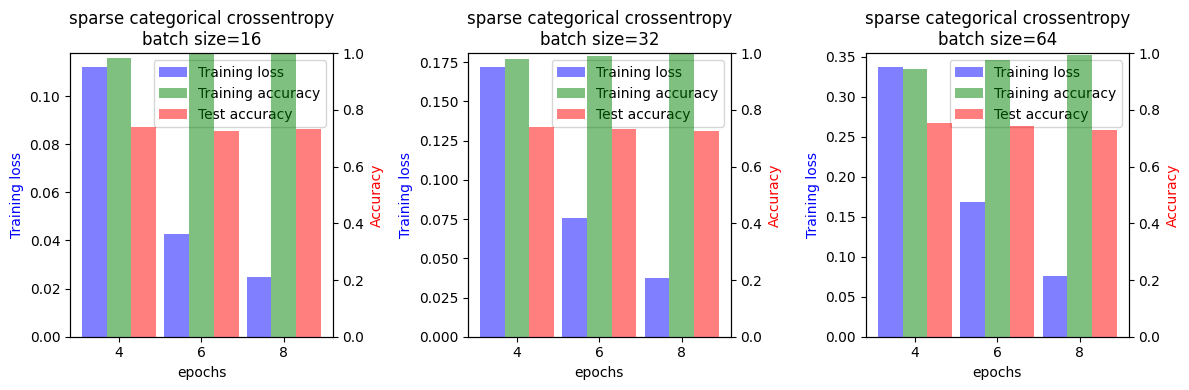

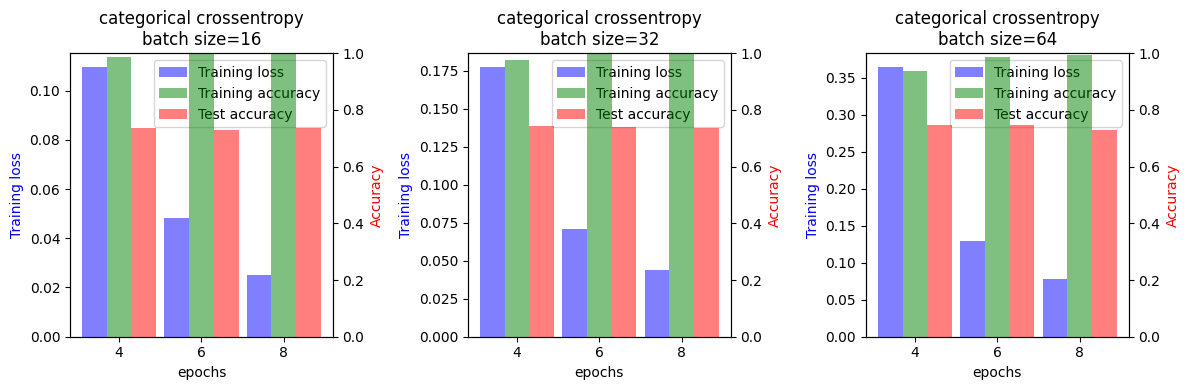

In [64]:
##Changed parameter
epoch_list = [4,6,8]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
batch_size_list = [16, 32, 64]
# Unchanged parameter
lr = 0.001

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode, lr, 'sparse_categorical_crossentropy', batch_size)
    df_dict_s[batch_size] = df
## categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(epoch_list, build_cnn_model, X_train_tokenized, y_train_one_hot, X_test_tokenized, y_test_one_hot, lr, 'categorical_crossentropy', batch_size)
    df_dict_c[batch_size] = df


# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

### distilBERT

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 5s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 5s 32ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 31ms/step


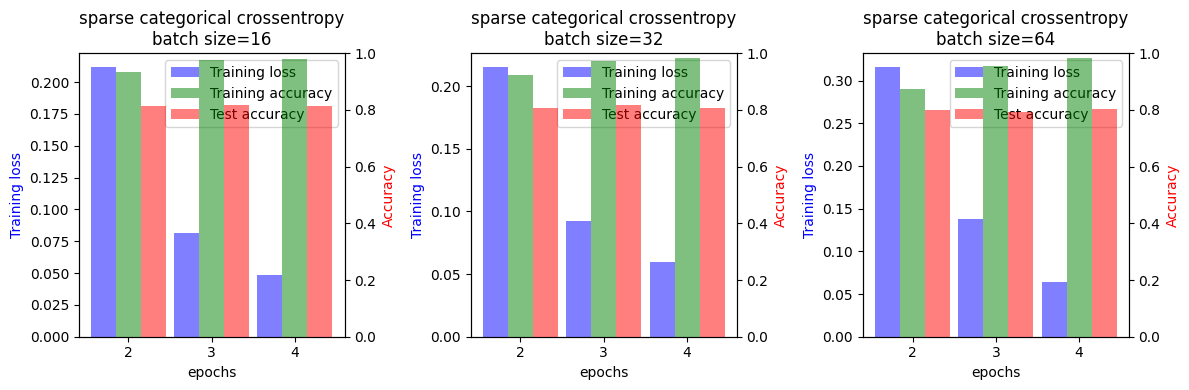

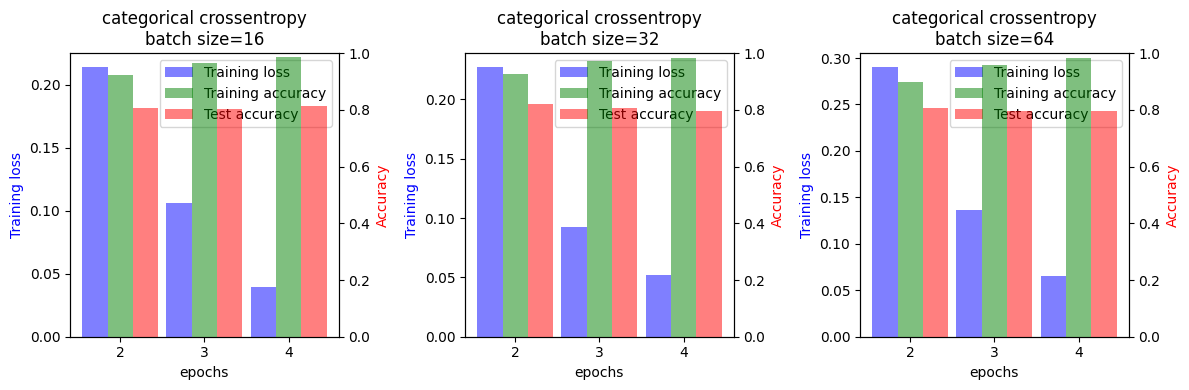

In [65]:
##Changed parameter
epoch_list = [2,3,4]
loss_list = ['sparse_categorical_crossentropy','categorical_crossentropy']
batch_size_list = [16, 32, 64]
# Unchanged parameter
lr = 3e-5

# Obtain result
df_dict_s = {}
df_dict_c = {}
## sparse_categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_encode,
    [X_test_input_ids, attention_mask_test], y_test_encode,
    lr, 'sparse_categorical_crossentropy', batch_size
)
    df_dict_s[batch_size] = df

## categorical_crossentropy
for batch_size in batch_size_list:
    df = create_result_df(
    epoch_list,
    build_distilbert_model,
    [X_train_input_ids, attention_mask_train], y_train_one_hot,
    [X_test_input_ids, attention_mask_test], y_test_one_hot,
    lr, 'categorical_crossentropy', batch_size
)
    df_dict_c[batch_size] = df

# Plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

## sparse_categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_s[lr],epoch_list,'s',index,lr)
plt.tight_layout()
plt.show()

## categorical_crossentropy
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 3 rows

for index, lr in enumerate(batch_size_list):
    visualize(df_dict_c[lr],epoch_list,'c',index,lr)
plt.tight_layout()
plt.show()

## 5.5  Visualize top 100 results

In [78]:
from sklearn.model_selection import train_test_split

X = df_raw['text']
y = df_raw['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### LSTM

In [67]:
## Best parameters set for LSTM
epoch = 10
loss = 'sparse_categorical_crossentropy'
lr = 0.0001
batch_size = 32

train_loss, train_acc, test_acc, y_pred = train_and_evaluate(build_lstm_model(), X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                                                             lr, loss, epoch, batch_size)

31/31 [==============================] - 1s 28ms/step


In [68]:
import numpy as np
import pandas as pd

predictions = [np.argmax(pred) for pred in y_pred]

num_samples = 100
samples = X_test.iloc[:num_samples]
true_labels = y_test.iloc[:num_samples]

predicted_labels = predictions[:num_samples]
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}

reverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = [reverse_label_map[label] for label in predicted_labels]

data = {
    'Text': samples.values,
    'True Sentiment': true_labels.values,
    'Predicted Sentiment': predicted_labels
}

df = pd.DataFrame(data)
df



,Text,True Sentiment,Predicted Sentiment
0,The company serves customers in various indust...,neutral,neutral
1,Officials did not disclose the contract value .,neutral,neutral
2,The extracted filtrates are very high in clari...,neutral,neutral
3,The tool is a patent pending design that allow...,neutral,neutral
4,"In Finland , the corresponding service is Alma...",neutral,neutral
...,...,...,...
95,"Operating loss totalled EUR 12.7 mn , compared...",negative,positive
96,17 March 2011 - Goldman Sachs estimates that t...,negative,neutral
97,Liora 's got a brand-new bag .,neutral,neutral
98,The Filter Tips cover the volume range from 0....,neutral,neutral


In [69]:

matches = (df['True Sentiment'] == df['Predicted Sentiment']).sum()


percentage_matches = (matches / num_samples) * 100


print(f"accuracy: {percentage_matches:.0f}%")


accuracy: 75%


### MLP

In [70]:
## Best parameters set for MLP
epoch = 6
loss = 'sparse_categorical_crossentropy'
lr = 0.001
batch_size = 32

train_loss, train_acc, test_acc, y_pred = train_and_evaluate(build_mlp_model(), X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                                                             lr, loss, epoch, batch_size)

31/31 [==============================] - 0s 1ms/step


In [71]:
import numpy as np
import pandas as pd

predictions = [np.argmax(pred) for pred in y_pred]

num_samples = 100
samples = X_test.iloc[:num_samples]
true_labels = y_test.iloc[:num_samples]

predicted_labels = predictions[:num_samples]
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}

reverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = [reverse_label_map[label] for label in predicted_labels]

data = {
    'Text': samples.values,
    'True Sentiment': true_labels.values,
    'Predicted Sentiment': predicted_labels
}

df = pd.DataFrame(data)
df

,Text,True Sentiment,Predicted Sentiment
0,The company serves customers in various indust...,neutral,neutral
1,Officials did not disclose the contract value .,neutral,neutral
2,The extracted filtrates are very high in clari...,neutral,neutral
3,The tool is a patent pending design that allow...,neutral,neutral
4,"In Finland , the corresponding service is Alma...",neutral,neutral
...,...,...,...
95,"Operating loss totalled EUR 12.7 mn , compared...",negative,negative
96,17 March 2011 - Goldman Sachs estimates that t...,negative,neutral
97,Liora 's got a brand-new bag .,neutral,neutral
98,The Filter Tips cover the volume range from 0....,neutral,neutral


In [72]:
matches = (df['True Sentiment'] == df['Predicted Sentiment']).sum()

percentage_matches = (matches / num_samples) * 100


print(f"accuracy: {percentage_matches:.0f}%")


accuracy: 79%


### CNN

In [73]:
## Best parameters set for CNN
epoch = 6
loss = 'sparse_categorical_crossentropy'
lr = 0.0001
batch_size = 32

train_loss, train_acc, test_acc, y_pred = train_and_evaluate(build_cnn_model(), X_train_tokenized, y_train_encode, X_test_tokenized, y_test_encode,
                                                             lr, loss, epoch, batch_size)

31/31 [==============================] - 0s 1ms/step


In [74]:
predictions = [np.argmax(pred) for pred in y_pred]

num_samples = 100
samples = X_test.iloc[:num_samples]
true_labels = y_test.iloc[:num_samples]

predicted_labels = predictions[:num_samples]
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}

reverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = [reverse_label_map[label] for label in predicted_labels]

data = {
    'Text': samples.values,
    'True Sentiment': true_labels.values,
    'Predicted Sentiment': predicted_labels
}

df = pd.DataFrame(data)
df

,Text,True Sentiment,Predicted Sentiment
0,The company serves customers in various indust...,neutral,neutral
1,Officials did not disclose the contract value .,neutral,neutral
2,The extracted filtrates are very high in clari...,neutral,neutral
3,The tool is a patent pending design that allow...,neutral,neutral
4,"In Finland , the corresponding service is Alma...",neutral,neutral
...,...,...,...
95,"Operating loss totalled EUR 12.7 mn , compared...",negative,positive
96,17 March 2011 - Goldman Sachs estimates that t...,negative,neutral
97,Liora 's got a brand-new bag .,neutral,neutral
98,The Filter Tips cover the volume range from 0....,neutral,neutral


In [75]:
matches = (df['True Sentiment'] == df['Predicted Sentiment']).sum()

percentage_matches = (matches / num_samples) * 100

print(f"accuracy: {percentage_matches:.0f}%")


accuracy: 66%


### distilBERT

In [79]:
## Best parameters set for bert
epoch = 3
loss = 'sparse_categorical_crossentropy'
lr = 3e-5
batch_size = 32

bert_model, tokenizer = build_distilbert_model(max_length=100, num_labels=3, dropout_rate=0.4, learning_rate=3e-5)
X_train_bert = [X_train_input_ids, attention_mask_train]
y_train_bert = y_train_encode
X_test_bert = [X_test_input_ids, attention_mask_test]
y_test_bert = y_test_encode

train_loss, train_acc, test_acc, y_pred = train_and_evaluate(bert_model, X_train_bert, y_train_bert, X_test_bert, y_test_bert,
                                                             lr, loss, epoch, batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


31/31 [==============================] - 4s 30ms/step


In [80]:
predictions = [np.argmax(pred) for pred in y_pred]

num_samples = 100
samples = X_test.iloc[:num_samples]
true_labels = y_test.iloc[:num_samples]

predicted_labels = predictions[:num_samples]
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}

reverse_label_map = {v: k for k, v in label_map.items()}

predicted_labels = [reverse_label_map[label] for label in predicted_labels]

data = {
    'Text': samples.values,
    'True Sentiment': true_labels.values,
    'Predicted Sentiment': predicted_labels
}

df = pd.DataFrame(data)
df

,Text,True Sentiment,Predicted Sentiment
0,The company serves customers in various indust...,neutral,neutral
1,Officials did not disclose the contract value .,neutral,neutral
2,The extracted filtrates are very high in clari...,neutral,neutral
3,The tool is a patent pending design that allow...,neutral,neutral
4,"In Finland , the corresponding service is Alma...",neutral,neutral
...,...,...,...
95,"Operating loss totalled EUR 12.7 mn , compared...",negative,negative
96,17 March 2011 - Goldman Sachs estimates that t...,negative,negative
97,Liora 's got a brand-new bag .,neutral,neutral
98,The Filter Tips cover the volume range from 0....,neutral,neutral


In [81]:
matches = (df['True Sentiment'] == df['Predicted Sentiment']).sum()

percentage_matches = (matches / num_samples) * 100

print(f"accuracy: {percentage_matches:.0f}%")


accuracy: 82%
